<a href="https://colab.research.google.com/github/manjitullal/Lung-Diseases-Detection/blob/main/Image_Segmentation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

# download data from kaggle 

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/datasets/kaggle/kaggle.json ~/.kaggle/

Mounted at /content/drive


In [ ]:
! kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

# unzip the data 

! unzip chest-xray-masks-and-labels.zip

100% 9.56G/9.58G [01:56<00:00, 106MB/s]
100% 9.58G/9.58G [01:56<00:00, 88.4MB/s]
Archive:  chest-xray-masks-and-labels.zip
  inflating: Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0013_0.png  
  inflating: Lung Segmentation

# Image Segmentation 
## using UNET
### on a kaggle dataset

https://arxiv.org/abs/1505.04597

In [ ]:
import numpy as np
from torch.utils.data import DataLoader,Dataset
import os
import random
import cv2
from PIL import Image
from skimage import io

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
from torch import optim
import matplotlib.pyplot as plt

import argparse
import logging
import os
import sys

import time
import copy

path = '/content/drive/MyDrive/Projects/DS5500/imagesegmentation_checkpoint/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class LungSegDataset(Dataset): # inherit from torch.utils.data.Dataset
    "Lung sengmentation dataset."
    def __init__(self,root_dir = os.path.join(os.getcwd(),"data/Lung Segmentation"),split = "train", transforms = None , shuffle = True):
        """
        Args:
        :param root_dir (str):
        :param split (str):
        :param transforms (callable, optional) :
        """
        self.root_dir = root_dir
        self.split = split # train / val / test
        self.transforms = transforms

        # data
        # train set : CHN
        # test/validation set : MCU
        self.image_path = self.root_dir + '/CXR_png'
        image_file =  os.listdir(self.image_path)
        self.train_image_file = [fName for fName in image_file if "CHNCXR" in fName]
        self.train_image_idx = sorted([int(fName.split("_")[1]) for fName in self.train_image_file])

        self.eval_image_file = [fName for fName in image_file if "MCUCXR" in fName]
        self.eval_image_idx = sorted([int(fName.split("_")[1]) for fName in self.eval_image_file])

        # target
        self.mask_path = os.path.join(self.root_dir,'masks')
        mask_file = os.listdir(self.mask_path)
        self.train_mask_file = [fName for fName in mask_file if "CHNCXR" in fName]
        self.train_mask_idx = sorted([int(fName.split("_")[1]) for fName in self.train_mask_file])

        self.eval_mask_file = [fName for fName in mask_file if "MCUCXR" in fName]
        self.eval_mask_idx = sorted([int(fName.split("_")[1]) for fName in self.eval_mask_file])

        # train/ val / test
        # for train set, we use CHN
        # for test and validation set, we use MCU
        self.train_idx = [idx for idx in self.train_image_idx if idx in self.train_mask_idx]
        self.eval_idx = [idx for idx in self.eval_image_idx if idx in self.eval_mask_idx]
        self.val_idx = self.eval_idx[:int(0.5*len(self.eval_idx))]
        self.test_idx = self.eval_idx[int(0.5*len(self.eval_idx)):]

        self.data_file = {"train"  : {"image":self.train_image_file , "mask": self.train_mask_file},
                           "val"   : {"image":self.eval_image_file  , "mask": self.eval_mask_file },
                           "test"  : {"image":self.eval_image_file  , "mask": self.eval_mask_file}}

        self.data_idx ={"train" : self.train_idx,
                        "val"   : self.val_idx,
                        "test"  : self.test_idx}

    def __len__(self):
        return len(self.data_idx[self.split])

    def __getitem__(self, idx):
        idx = self.data_idx[self.split][idx]
        # set index
        for fName in self.data_file[self.split]["image"]:
            file_idx = int(fName.split('_')[1])
            if idx == file_idx:
                img_fName = fName
        img_path = os.path.join(self.image_path, img_fName)
        img = Image.open(img_path).convert('LA')  # open as PIL Image and set Channel = 1

        for fName in self.data_file[self.split]["mask"]:
            file_idx = int(fName.split('_')[1])
            if idx == file_idx:
                mask_fName = fName
        mask_path = os.path.join(self.mask_path, mask_fName)
        mask = Image.open(mask_path)  # PIL Image

        sample = {'image': img, 'mask': mask}

        if self.transforms:
            sample = self.transforms(sample)

        if isinstance(img,torch.Tensor) and isinstance(mask, torch.Tensor):
            assert img.size == mask.size
        return sample

In [ ]:
class UNetConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3 , padding = True):
        super().__init__()
        self.double_conv = nn.Sequential(
            # Usually Conv -> BatchNormalization -> Activation
            nn.Conv2d(in_channels , out_channels , kernel_size= kernel_size , padding = int(padding)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=int(padding)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self,inp):
        return self.double_conv(inp)

class Down(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            UNetConvBlock(in_channels,out_channels)
        )

    def forward(self,x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self,in_channels , out_channels , bilinear = False):
        super(Up,self).__init__()

        if bilinear: # use the normal conv to reduce the number of channels
            self.up = nn.Upsample(scale_factor=2, mode= 'bilinear', align_corners = True)
        else: # use Transpose convolution (the one that official UNet used)
            self.up = nn.ConvTranspose2d(in_channels//2 , in_channels // 2, kernel_size = 2,stride=2 )

        self.conv = UNetConvBlock(in_channels,out_channels)

    def forward(self,x1,x2):
        # input dim is CHW
        x1 = self.up(x1)

        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1 , [diffX // 2, diffX - diffX // 2,
                         diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1] , dim = 1)
        out = self.conv(x)
        return out

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes , bilinear = False):
        super(UNet,self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.in_conv = UNetConvBlock(self.n_channels , 64)
        self.Down1 = Down(64 , 128)
        self.Down2 = Down(128, 256)
        self.Down3 = Down(256, 512)
        self.Down4 = Down(512, 512)
        self.Up1 = Up(512 + 512, 256 , self.bilinear)
        self.Up2 = Up(256 + 256, 128 , self.bilinear)
        self.Up3 = Up(128 + 128 , 64 , self.bilinear)
        self.Up4 = Up(64 + 64, 64 , self.bilinear)
        self.out_conv = OutConv(64, n_classes)

    def forward(self,x):
        x1 = self.in_conv(x)
        x2 = self.Down1(x1)
        x3 = self.Down2(x2)
        x4 = self.Down3(x3)
        x5 = self.Down4(x4)
        x = self.Up1(x5,x4)
        x = self.Up2(x ,x3)
        x = self.Up3(x ,x2)
        x = self.Up4(x ,x1)
        out = self.out_conv(x)
        return out

#UNet(3,10)

In [ ]:
class GrayScale(object):
    def __call__(self,sample):
        from torchvision.transforms import Grayscale
        Grayscale = Grayscale()
        sample['image'] = Grayscale(sample['image'])
        return sample

class Resize(object):
    """
    Resize the input PIL Image to the given size.
    """
    def __init__(self,img_size):
        assert isinstance(img_size , (int,tuple))
        self.img_size = img_size

    def __call__(self,sample):
        img , mask = sample['image'],sample['mask']
        Resize = transforms.Resize((self.img_size,self.img_size))
        sample['image'],sample['mask'] = Resize(img), Resize(mask)
        return sample

class RandomRotation(object):
    def __init__(self, degrees, resample=False, expand=False, center=None, fill=0):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center
        self.fill = fill

    @staticmethod
    def get_params(degrees):
        angle = random.uniform(degrees[0], degrees[1])
        return angle

    def __call__(self, img):
        angle = self.get_params(self.degrees)
        return F.rotate(img, angle, self.resample, self.expand, self.center, self.fill)

    def __repr__(self):
        format_string = self.__class__.__name__ + '(degrees={0}'.format(self.degrees)
        format_string += ', resample={0}'.format(self.resample)
        format_string += ', expand={0}'.format(self.expand)
        if self.center is not None:
            format_string += ', center={0}'.format(self.center)
        format_string += ')'
        return format_string


class ColorJitter(object):
    def __init__(self,brightness=0, contrast=0, saturation=0, hue=0):
        from torchvision.transforms import ColorJitter
        self.ColorJitter = ColorJitter(brightness, contrast, saturation, hue)

    def __call__(self,sample):
        return {"image":self.ColorJitter(sample["image"]),
                "mask" :sample["mask"]}

class ToTensor(object):
    """convert ndarrays in sample to Tensors"""
    def __call__(self,sample):
        from torchvision.transforms import ToTensor
        ToTensor = ToTensor()
        img , mask = sample['image'],sample['mask']
        sample['image'],sample['mask'] = ToTensor(img) ,ToTensor(mask)
        return sample

class RandomVerticalFlip(object):
    def __init__(self, p =0.5):
        self.p = p
    def __call__(self,sample):
        from torchvision.transforms.functional import vflip as vertical_flip
        img , mask = sample['image'],sample['mask']
        if random.random() < self.p:
                sample['image'], sample['mask'] = vertical_flip(img), vertical_flip(mask)
        return sample

class RandomHorizontalFlip(object):
    def __init__(self, p = 0.5):
        self.p = p

    def __call__(self, sample):
        from torchvision.transforms.functional import hflip as horizontal_flip
        img , mask = sample['image'],sample['mask']
        if random.random() < self.p:
                sample['image'], sample['mask'] = horizontal_flip(img), horizontal_flip(mask)
        return sample

class ToPILImage(object):
    def __call__(self,sample):
        from torchvision.transforms import ToPILImage
        img , mask = sample['image'],sample['mask']
        ToPILImage = ToPILImage()
        sample['image'], sample['mask'] = ToPILImage(img),ToPILImage(mask)
        return sample

In [ ]:
def train_and_validate(net,criterion, optimizer, scheduler, dataloader,device,epochs, load_model = None):

    """load checkpoint pt"""
    if load_model:
        print("load model from", load_model)
        # net.load_state_dict(torch.load(load_model))
        checkpoint = torch.load(load_model)
        net.load_state_dict(checkpoint['model_state_dict'])
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        loss = checkpoint['loss']

    history = {'train':{'epoch':[], 'loss' : [] , 'acc':[]},
               'val'  :{'epoch':[], 'loss' : [] , 'acc':[]}}

    best_acc = 0.90
    best_loss = 10000000000
    start = time.time()
    for epoch in range(epochs):
        if load_model:
            epoch += start_epoch
            epochs += start_epoch
        print("-" * 30)
        print(f"Epoch {epoch + 1}/{epochs}")
    
        since = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # set model to training mode
            else:
                print("-" * 10)
                net.eval() # set model to evaluate mode

            running_loss = 0.0
            running_correct = 0
            dataset_size = 0
            """Iterate over data"""
            for batch_idx, sample in enumerate(dataloader[phase]):
                imgs , true_masks = sample['image'],sample['mask']
                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32
                true_masks = true_masks.to(device=device, dtype=mask_type)

                # zero the parameter gradients
                optimizer.zero_grad()

                """forward"""
                with torch.set_grad_enabled(phase == 'train'):
                    masks_pred = net(imgs)
                    loss = criterion(masks_pred, true_masks)
                    running_loss += loss.item()

                    """backward + optimize only if in training phase"""
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                """ statistics """
                dataset_size += imgs.size(0)
                running_loss += loss.item() * imgs.size(0)
                pred = torch.sigmoid(masks_pred) > 0.5
                running_correct += (pred == true_masks).float().mean().item() * imgs.size(0)
                running_acc = running_correct/dataset_size

            """ statistics """
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_correct / dataset_size
            print('{} Loss {:.5f}\n{} Acc {:.2f}'
                  .format(phase, epoch_loss,phase,epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                torch.save({
                    'epoch':epoch + 1,
                    'model_state_dict':best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': best_acc
                },os.path.join(path,'best_checkpoint[epoch_{}].pt'.format(epoch + 1)))
                print("Achived best result! save checkpoint.")
                print("val acc = ", best_acc)
            history[phase]['epoch'].append(epoch)
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)

        scheduler.step(history['val']['acc'][-1])

        time_elapsed = time.time() - since
        print("One Epoch Complete in {:.0f}m {:.0f}s".format(time_elapsed//60 , time_elapsed%60))

        time_elapsed = time.time() - start
        min, sec = time_elapsed//60 , time_elapsed % 60
        print("Total Training time {:.0f}min {:.0f}sec".format(min,sec))

In [ ]:
def get_args():

    parser = argparse.ArgumentParser(description = "U-Net for Lung Segmentation" ,
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # set your environment
    parser.add_argument('--gpu', type=str, default = '0')
    parser.add_argument('--n_workers', type =int , default = 4 , help = "The number of workers for dataloader")

    # arguments for training
    parser.add_argument('--img_size', type = int , default = 512,)
    parser.add_argument('--epochs', type=int , default = 50 )
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--lr', type=float, default=0.1)

    parser.add_argument('--load_model', type=str, default=None, help='.pth file path to load model')
    parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

    return parser.parse_args()

In [ ]:
args = get_args()

# set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu # default: '0'

# set model
model = UNet(n_channels=1, n_classes=1).to(device)
if len(args.gpu) > 1: # if multi-gpu
    model = torch.nn.DataParallel(model)

img_size = args.img_size #default: 512

# set transforms for dataset
train_transforms = transforms.Compose([
    #Data Augmentations
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    GrayScale(),
    Resize(img_size),
    ToTensor(),

])
eval_transforms = transforms.Compose([
    GrayScale(),
    Resize(img_size),
    ToTensor()
])

# set Dataset and DataLoader
train_dataset = LungSegDataset(transforms=train_transforms)
val_dataset = LungSegDataset(split='val',transforms=eval_transforms)
test_dataset = LungSegDataset(split = 'test',transforms=eval_transforms)

from torch.utils.data import DataLoader
dataloader = {'train' : DataLoader(dataset = train_dataset, batch_size=args.batch_size, num_workers=args.n_workers, shuffle=True),
              'val' :   DataLoader(dataset = val_dataset  , batch_size=args.batch_size, num_workers=args.n_workers, shuffle=True),
              'test':   DataLoader(dataset = test_dataset , batch_size=args.batch_size, num_workers=args.n_workers, shuffle=True)}


# checkpoint dir
checkpoint_dir = os.path.join(os.getcwd(), 'checkpoint')
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
checkpoint_path = args.load_model


# set optimizer
optimizer = optim.Adam(model.parameters(), lr= args.lr, weight_decay=1e-5)

# learning rate scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
## option 2.
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
#train_and_validate(net=model,criterion=criterion,optimizer=optimizer,dataloader=dataloader,device=device,epochs=args.epochs, scheduler=scheduler,load_model=checkpoint_path)

In [ ]:
#model = UNet(n_channels=1, n_classes=1).to(device)

checkpoint = torch.load(path+'best_checkpoint[epoch_31].pt')
model = UNet(n_channels=1, n_classes=1)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

UNet(
  (in_conv): UNetConvBlock(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): UNetConvBlock(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-

In [ ]:
def test(model, phase):
  running_loss = 0.0
  running_correct = 0
  dataset_size = 0
  prediction = []
  label = []

  for batch_idx, sample in enumerate(dataloader[phase]):
      imgs , true_masks = sample['image'],sample['mask']
      imgs = imgs.to(device=device, dtype=torch.float32)
      mask_type = torch.float32
      true_masks = true_masks.to(device=device, dtype=mask_type)

      model.eval()
      with torch.no_grad():
        masks_pred = model(imgs)
        loss = criterion(masks_pred, true_masks)
        running_loss += loss.item()

        """ statistics """
        dataset_size += imgs.size(0)
        running_loss += loss.item() * imgs.size(0)
        pred = torch.sigmoid(masks_pred) > 0.5
        running_correct += (pred == true_masks).float().mean().item() * imgs.size(0)
        running_acc = running_correct/dataset_size

        prediction.append(torch.sigmoid(masks_pred))
        label.append(true_masks)

  """ statistics """
  epoch_loss = running_loss / dataset_size
  epoch_acc = running_correct / dataset_size
  print('{} Loss {:.5f}\n{} Acc {:.2f}'.format(phase, epoch_loss,phase,epoch_acc))
  return prediction, label

In [ ]:
prediction, label = test(model, 'test')

test Loss 0.29726
test Acc 0.93


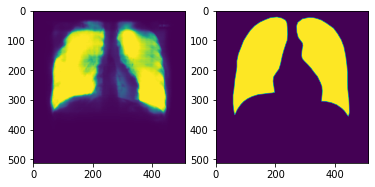

In [ ]:
import matplotlib.pyplot as plt
#https://www.kaggle.com/kmader/use-roc-curves-to-evaluate-segmentation-methods

x = prediction[1][0,0,:].detach().cpu()
y = label[1][0,0,:].detach().cpu()

_, ax = plt.subplots(1,2)
ax[0].imshow(x)
ax[1].imshow(y)
plt.show()

In [ ]:
predictions = torch.cat(prediction, axis=0)
labels = torch.cat(label, axis=0)

In [ ]:
predictions = predictions[:,0,:].detach().cpu().numpy()
labels = labels[:,0,:].detach().cpu().numpy()

In [ ]:
from sklearn.metrics import roc_curve, auc 
ground_truth_labels = labels.astype(int).ravel()
score_value = predictions.ravel()

fpr, tpr, _ = roc_curve(ground_truth_labels, score_value)
roc_auc = auc(fpr,tpr)

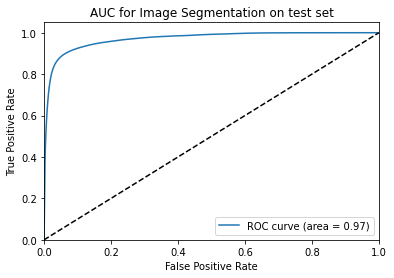

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('AUC for Image Segmentation on test set')
ax.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ground_truth_labels, score_value)
average_precision

0.9306811451871566

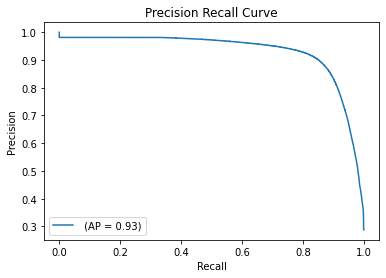

In [ ]:
from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay)

precision, recall, _ = precision_recall_curve(ground_truth_labels, score_value)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name='')
disp.plot() 
plt.title('Precision Recall Curve')
plt.show()